User-centric Geographic Analysis
===

Try to assign locations to users.



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle
import json

from datetime import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/geo_data"
os.makedirs(working_dir, exist_ok=True)
assert os.path.exists(working_dir)

In [4]:
journal_geo_filepath = os.path.join(working_dir, "journal_geo_data.csv")
gb_geo_filepath = os.path.join(working_dir, "gb_geo_data.csv")

In [5]:
!wc -l {journal_geo_filepath}

13255023 /home/srivbane/shared/caringbridge/data/projects/sna-social-support/geo_data/journal_geo_data.csv


In [6]:
!wc -l {gb_geo_filepath}

76810342 /home/srivbane/shared/caringbridge/data/projects/sna-social-support/geo_data/gb_geo_data.csv


### Filter the geographic data to include only valid users

In [7]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362345

In [8]:
journal_geo_filepath = os.path.join(working_dir, "journal_geo_data.csv")
gb_geo_filepath = os.path.join(working_dir, "gb_geo_data.csv")

In [9]:
journal_geo_filtered_filepath = os.path.join(working_dir, "journal_geo_filtered.csv")
gb_geo_filtered_filepath = os.path.join(working_dir, "gb_geo_filtered.csv")

In [133]:
for input_filepath, output_filepath in [(journal_geo_filepath, journal_geo_filtered_filepath), 
                                        (gb_geo_filepath, gb_geo_filtered_filepath)]:
    with open(input_filepath, 'r') as infile:
        with open(output_filepath, 'w') as outfile:
            for line in tqdm(infile, desc=os.path.basename(input_filepath)):
                if line.strip() == "":
                    continue
                user_id = line.split(",")[0]
                if user_id == 'None':
                    continue
                user_id = int(user_id)
                if user_id in valid_user_ids:
                    outfile.write(line)
                
print("Finished filtering files.")

journal_geo_data.csv: 13255023it [00:28, 465086.92it/s]
gb_geo_data.csv: 26736773it [02:34, 173288.84it/s]


Finished filtering files.


In [10]:
!wc -l {journal_geo_filtered_filepath}

12090538 /home/srivbane/shared/caringbridge/data/projects/sna-social-support/geo_data/journal_geo_filtered.csv


In [11]:
!wc -l {gb_geo_filtered_filepath}

2213981 /home/srivbane/shared/caringbridge/data/projects/sna-social-support/geo_data/gb_geo_filtered.csv


### Load geographic info into dataframes

We load only the filtered data.

In [12]:
cols = ['user_id', 'site_id', 'created_at', 'country', 'subdiv_count', 'state', 'city', 'lat', 'long', 'acc_radius']

In [13]:
gb_df = pd.read_csv(gb_geo_filtered_filepath, header=None, names=cols)
len(gb_df)

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2213981

In [14]:
j_df = pd.read_csv(journal_geo_filtered_filepath, header=None, names=cols)
len(j_df)

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


12090538

In [15]:
gb_df['type'] = 'guestbook'
j_df['type'] = 'journal'

In [16]:
df = pd.concat([gb_df, j_df])
len(df)

14304519

In [17]:
df.head()

,user_id,site_id,created_at,country,subdiv_count,state,city,lat,long,acc_radius,type
0,322059,20005,1371420989000,NOT_FOUND,NaN,NaN,NaN,NaN,NaN,NaN,guestbook
1,5968472,68593,1371432498000,US,1.0,NY,Northville,43.2662,-74.2288,20,guestbook
2,21573557,557835,1371429583000,NOT_FOUND,NaN,NaN,NaN,NaN,NaN,NaN,guestbook
3,20049997,77628,1371440716000,US,1.0,GA,Woodstock,34.1078,-84.5026,10,guestbook
4,24353953,604503,1371442462000,US,1.0,IL,Northbrook,42.1212,-87.8405,20,guestbook


### High-level descriptive statistics at the aggregate

In other words, we don't yet group by specific users for analysis.

In [18]:
for country, count in Counter(df.country).most_common()[:20]:
    print(f"{country:>11} {count:8} ({count/len(df)*100:5.2f}%)")

         US 13500933 (94.38%)
  NOT_FOUND   338604 ( 2.37%)
         CA   224200 ( 1.57%)
         CN    50903 ( 0.36%)
         GB    49540 ( 0.35%)
         AU    36581 ( 0.26%)
         NZ    12034 ( 0.08%)
         CO     7722 ( 0.05%)
         DE     7205 ( 0.05%)
         MX     5411 ( 0.04%)
         JP     4272 ( 0.03%)
         IN     4111 ( 0.03%)
         NL     3710 ( 0.03%)
         IE     3659 ( 0.03%)
         CH     3249 ( 0.02%)
         NO     3174 ( 0.02%)
         HK     2736 ( 0.02%)
         ZA     2604 ( 0.02%)
         SG     2496 ( 0.02%)
         PK     2366 ( 0.02%)


In [19]:
for state, count in Counter(df.state).most_common()[:20]:
    print(f"{state:>11} {count:8} ({count/len(df)*100:5.2f}%)")

       None  3668203 (25.64%)
         MN  1170520 ( 8.18%)
         TX   617064 ( 4.31%)
         CA   580954 ( 4.06%)
         NY   538879 ( 3.77%)
         WI   434251 ( 3.04%)
         NC   411429 ( 2.88%)
         OH   372449 ( 2.60%)
         WA   368578 ( 2.58%)
        nan   338638 ( 2.37%)
         IL   337195 ( 2.36%)
         FL   331497 ( 2.32%)
         GA   330715 ( 2.31%)
         TN   297072 ( 2.08%)
         MO   279225 ( 1.95%)
         PA   263965 ( 1.85%)
         IN   224639 ( 1.57%)
         VA   215106 ( 1.50%)
         MI   195253 ( 1.36%)
         CO   192013 ( 1.34%)


In [20]:
Counter(df[(df.acc_radius == df.acc_radius)&(df.acc_radius != 'None')].acc_radius.astype(int)).most_common()

[(1000, 4178572),
 (5, 2658906),
 (10, 2273023),
 (20, 2095568),
 (50, 980198),
 (100, 782476),
 (1, 471788),
 (200, 341178),
 (500, 183813)]

Considering only 675047 (4.72%) posts.


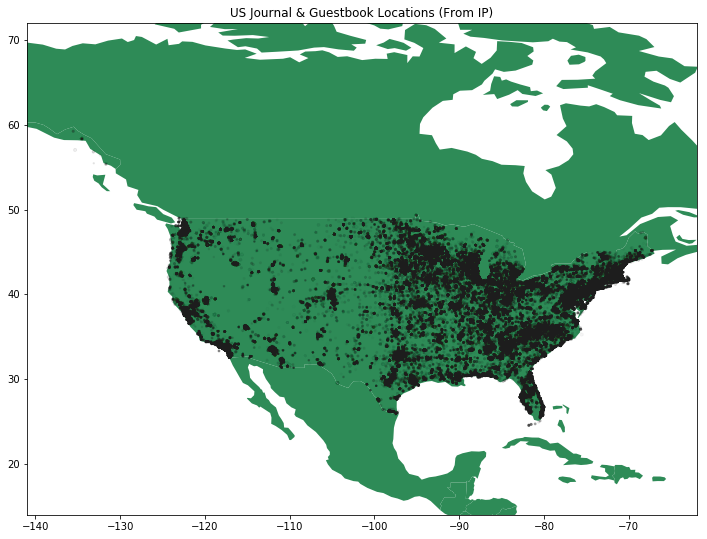

In [21]:
import geopandas as gpd
import geopandas.datasets
import shapely

us_df = df[(df.country == 'US')&(df.acc_radius == df.acc_radius)]
us_df = us_df.sample(frac=0.05)
print(f"Considering only {len(us_df)} ({len(us_df) / len(df) * 100:.2f}%) posts.")

world = gpd.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1,1, figsize=(12,12))

ax = world.plot(ax=ax, color="seagreen")

marker_size_map = {1000: 10,
                   500: 10,
                   200: 5, 
                   100: 4, 
                   50: 4, 
                   20: 4,
                   10: 2, 
                   5: 2,
                   1: 2
                  }

marker_color_map = {1000: plt.cm.Greys(0.9, alpha=0.01),
                   500: plt.cm.Greys(0.9, alpha=0.01),
                   200: plt.cm.Greys(0.9, alpha=0.02), 
                   100: plt.cm.Greys(0.9, alpha=0.04), 
                   50: plt.cm.Greys(0.9, alpha=0.04), 
                   20: plt.cm.Greys(0.9, alpha=0.08),
                   10: plt.cm.Greys(0.9, alpha=0.08), 
                   5: plt.cm.Greys(0.9, alpha=0.1),
                   1: plt.cm.Greys(0.9, alpha=0.1)
                  }

geometry = [shapely.geometry.Point(xy) for xy in zip(us_df.long.astype("float"), us_df.lat.astype("float"))]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(us_df[['user_id']], crs=crs, geometry=geometry)
gdf = gdf.to_crs(world.crs)  # just to ensure the coordinate system is the same
acc_radius_ints = us_df.acc_radius.astype(int)
markersizes = [marker_size_map[ar] for ar in acc_radius_ints]
colors = [marker_color_map[ar] for ar in acc_radius_ints]
ax = gdf.plot(ax=ax, color=colors, markersize=markersizes)

# some hacky estimates of North America coords
ax.set_xlim((-141,-62))
ax.set_ylim((14,72))

_ = ax.set_title("US Journal & Guestbook Locations (From IP)")

### Journal location analysis

In [107]:
j_df = pd.read_csv(journal_geo_filtered_filepath, header=None, names=cols)
len(j_df)

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,2,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


13255023

In [108]:
len(set(j_df.user_id))

289231

In [26]:
users = []
for user_id, group in tqdm(df.groupby('user_id', sort=False)):
    if type(user_id) != int and user_id == 'None':
        continue
    u = {
        'user_id': user_id,
        'total_updates': len(group),
        'total_geolinked_updates': np.sum(group.country != 'NOT_FOUND'),
        'country_set': set(group.country),
        'state_set': {s for s in set(group.state) if s==s},  # bit of magic to remove nans
        'country_counts': Counter(group.country),
        'state_counts': Counter(group.state)
    }
    
    if 'NOT_FOUND' in u['country_set']:
        u['country_set'].remove('NOT_FOUND')
    if 'None' in u['state_set']:
        u['state_set'].remove('None')
    
    users.append(u)
user_df = pd.DataFrame(users)
len(user_df)

100%|██████████| 263330/263330 [04:06<00:00, 1067.47it/s]


263330

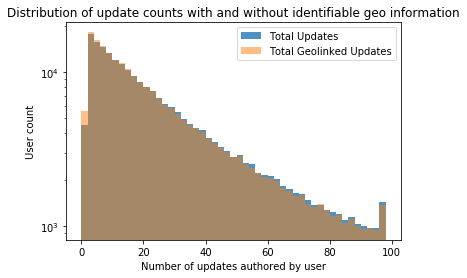

In [27]:
bins = range(0, 100, 2)
plt.hist(user_df.total_updates, label='Total Updates', log=True, bins=bins, alpha=0.8)
plt.hist(user_df.total_geolinked_updates, label='Total Geolinked Updates', log=True, bins=bins, alpha=0.5)

plt.title("Distribution of update counts with and without identifiable geo information")
plt.ylabel("User count")
plt.xlabel("Number of updates authored by user")

plt.legend()

plt.show()

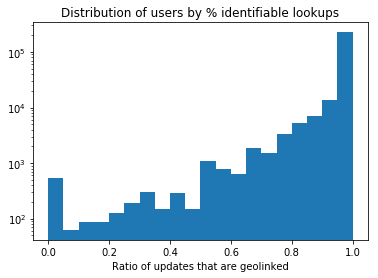

In [28]:
plt.hist(user_df.total_geolinked_updates / user_df.total_updates, log=True, bins=20)
plt.xlabel("Ratio of updates that are geolinked")
plt.title("Distribution of users by % identifiable lookups")
# 1.0 is 100% lookup succeeded, 0.0 is 0% lookup succeeded
plt.show()

In [29]:
# 0.6% of users authoring journal updates have ZERO successful IP lookups
len(user_df[(user_df.total_geolinked_updates / user_df.total_updates) == 0]), len(user_df[(user_df.total_geolinked_updates / user_df.total_updates) == 0]) / len(user_df)

(530, 0.0020126837048570234)

In [30]:
# 3.6% of users are registered as having IPs in different countries at different times
len(user_df[user_df.country_set.map(lambda country_set: len(country_set) > 1)]) / len(user_df)

0.04801959518474917

In [31]:
# Print the most common country co-occurrences
Counter([str(s) for s in user_df[user_df.country_set.map(lambda country_set: len(country_set) > 1)].country_set]).most_common()[:10]

[("{'CA', 'US'}", 5051),
 ("{'MX', 'US'}", 561),
 ("{'PK', 'US'}", 518),
 ("{'CN', 'US'}", 515),
 ("{'GB', 'US'}", 351),
 ("{'DE', 'US'}", 327),
 ("{'CO', 'US'}", 269),
 ("{'US', 'CN'}", 230),
 ("{'IE', 'US'}", 228),
 ("{'AU', 'US'}", 194)]

In [32]:
# 42.6% of users are registered as having IPs in at least two different states
len(user_df[user_df.state_set.map(lambda state_set: len(state_set) > 1)]) / len(user_df)

0.5008164660312155

In [33]:
Counter([str(s) for s in user_df[user_df.state_set.map(lambda state_set: len(state_set) > 1)].state_set]).most_common()[:10]

[("{'MN', 'WI'}", 2427),
 ("{'SC', 'NC'}", 1183),
 ("{'IL', 'IN'}", 890),
 ("{'OR', 'WA'}", 870),
 ("{'MN', 'SD'}", 836),
 ("{'TX', 'CA'}", 759),
 ("{'IA', 'MN'}", 655),
 ("{'FL', 'MN'}", 650),
 ("{'IL', 'MO'}", 616),
 ("{'MN', 'ND'}", 609)]

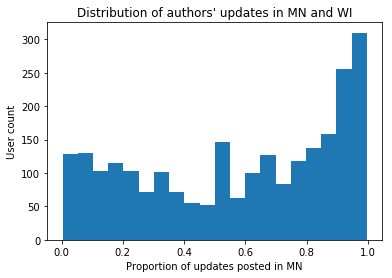

In [34]:
# examine specifically people split between MN and WI....
subset = user_df[user_df.state_set.map(lambda state_set: len(state_set) == 2 and 'WI' in state_set and 'MN' in state_set)]
x = []
for state_counts in subset.state_counts:
    mn_count = state_counts['MN']
    wi_count = state_counts['WI']
    mn_proportion = mn_count / (mn_count + wi_count)
    x.append(mn_proportion)
    
plt.hist(x, bins=20)
plt.title("Distribution of authors' updates in MN and WI")
plt.ylabel("User count")
plt.xlabel("Proportion of updates posted in MN")
plt.show()

The plot above shows that there is a relatively diverse set of proportions as far as the MN/WI split goes, so it's not the case that it would be easy to assign a single state label to these users.

#### Investigating MN vs WI  using logistic regression

In [117]:
import statsmodels.api as sm

In [118]:
# for the MN/WI users, is there an association between time since site start and WI vs MN?
# we only include users with at least 10 geolinked updates
subset = user_df[(user_df.state_set.map(lambda state_set: len(state_set) == 2 and 'WI' in state_set and 'MN' in state_set))&(user_df.total_geolinked_updates >= 10)]

subset_j_df = j_df[(j_df.state == 'MN')|(j_df.state == 'WI')]
x = []
y = []

for user_id in tqdm(subset.user_id):
    user_subset = subset_j_df[subset_j_df.user_id == user_id]
    created_at = user_subset.created_at.astype(int)
    is_mn_authored = user_subset.state == 'MN'
    created_at = (created_at - np.min(created_at)) / (1000 * 60 * 60 * 24) # convert to days since first update
    x.extend(created_at)
    y.extend(is_mn_authored)
    #logit = sm.Logit(is_mn_authored, created_at)
    #result = logit.fit(disp=False)
    #print(result.summary())
    #print(f"coef={result.params.values[0]:.3f} p={result.pvalues.values[0]:.3f}")
    

100%|██████████| 2040/2040 [04:29<00:00,  7.80it/s]


In [119]:
logit = sm.Logit(y, np.log(np.array(x) + 1))
result = logit.fit(disp=1)
result.summary(yname='is_mn_authored', xname=['days_since_first_update'])

Optimization terminated successfully.
         Current function value: 0.683858
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         is_mn_authored   No. Observations:                85804
Model:                          Logit   Df Residuals:                    85803
Method:                           MLE   Df Model:                            0
Date:                Fri, 16 Aug 2019   Pseudo R-squ.:               -0.008499
Time:                        16:09:29   Log-Likelihood:                -58678.
converged:                       True   LL-Null:                       -58183.
                                        LLR p-value:                       nan
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
days_since_first_update     0.0619      0.002     39.638      0.000       0.059       0.065
===========================================================================================
"""

In [120]:
np.exp(result.params[0])
# 6.4% increase in probability of update being MN-authored if it was authored 1-logday later

1.0638404112213262

In [126]:
np.log(2) - np.log(1)

0.6931471805599453

In [127]:
from scipy.stats.stats import pearsonr
coef, p = pearsonr(y, x)
print(f"Pearson's correlation coefficient={coef:.3f} p={p:.3f} n={len(x)}")
# not a very strong correlation,  but it is positive, in keeping with the coefficient

Pearson's correlation coefficient=0.006 p=0.065 n=85804


### More consistency analysis

In [14]:
users = []
for user_id, group in tqdm(df.groupby('user_id', sort=False)):
    if type(user_id) != int and user_id == 'None':
        continue
    u = {
        'user_id': user_id,
        'total_updates': len(group),
        'total_geolinked_updates': np.sum(group.country != 'NOT_FOUND'),
        'country_set': set(group.country),
        'state_set': {s for s in set(group.state) if s==s},  # bit of magic to remove nans
        'country_counts': Counter(group.country),
        'state_counts': Counter(group.state)
    }
    
    if 'NOT_FOUND' in u['country_set']:
        u['country_set'].remove('NOT_FOUND')
    if 'None' in u['state_set']:
        u['state_set'].remove('None')
    
    users.append(u)
user_df = pd.DataFrame(users)
len(user_df)

100%|██████████| 263330/263330 [04:25<00:00, 989.97it/s] 


263330

In [38]:
us_user_df = user_df[user_df.country_set.map(lambda country_set: 'US' in country_set and len(country_set) == 1)]
len(us_user_df) / len(user_df)

0.9331067481866859

In [39]:
multistate_user_df = us_user_df[us_user_df.state_set.map(lambda state_set: len(state_set) > 1)]
len(multistate_user_df) / len(us_user_df)

0.4880328836253383

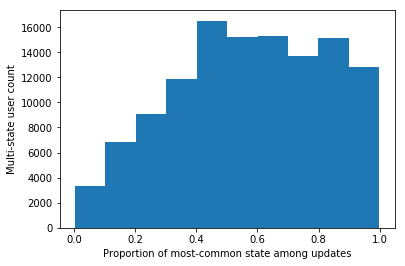

In [50]:
# Proportion of most common state among multistate users
props = []
for total_geolinked_updates, state_counts in zip(multistate_user_df.total_geolinked_updates, multistate_user_df.state_counts):
    most_common_state, most_common_state_count = "", 0
    for state, count in state_counts.most_common():
        if type(state) == str and len(state) == 2:
            most_common_state = state
            most_common_state_count = count
            break
    prop = most_common_state_count / total_geolinked_updates
    props.append(prop)

plt.hist(props)
plt.xlabel("Proportion of most-common state among updates")
plt.ylabel("Multi-state user count")
plt.show()

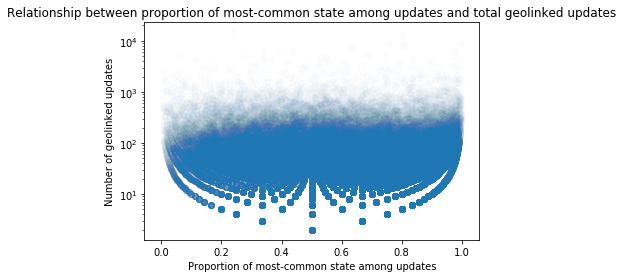

In [55]:
# Relationship between state proportion and total updates authored
props = []
for total_geolinked_updates, state_counts in zip(multistate_user_df.total_geolinked_updates, multistate_user_df.state_counts):
    most_common_state, most_common_state_count = "", 0
    for state, count in state_counts.most_common():
        if type(state) == str and len(state) == 2:
            most_common_state = state
            most_common_state_count = count
            break
    prop = most_common_state_count / total_geolinked_updates
    props.append((prop, total_geolinked_updates))

props = np.array(props)
plt.scatter(props[:,0], props[:,1], alpha=0.01)
plt.yscale('log')
plt.title("Relationship between proportion of most-common state among updates and total geolinked updates")
plt.ylabel("Number of geolinked updates")
plt.xlabel("Proportion of most-common state among updates")
plt.show()

If there is any [weak] relationship between number of geolinked updates and the proportion of the most common state, it is that a single high-proportion state is MORE common as the number of updates increases.

In [41]:
clear_state_assignment_counts = []
thresholds = np.linspace(0.5, 1, num=40)
for threshold in tqdm(thresholds):
    single_state_above_threshold_count = 0
    for total_geolinked_updates, state_counts in zip(multistate_user_df.total_geolinked_updates, multistate_user_df.state_counts):
        most_common_state, most_common_state_count = "", 0
        for state, count in state_counts.most_common():
            if type(state) == str and len(state) == 2:
                most_common_state = state
                most_common_state_count = count
                break
        if most_common_state_count / total_geolinked_updates >= threshold:
            single_state_above_threshold_count += 1
    clear_state_assignment_counts.append(single_state_above_threshold_count)

100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


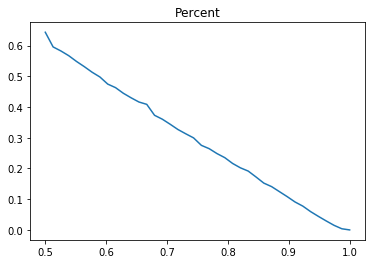

In [42]:
plt.plot(thresholds, np.array(clear_state_assignment_counts) / len(multistate_user_df))

plt.title("Percent")
plt.show()

In [43]:
# After assigning the most common >50% state as the single state assignment, 
# we are able to assign a single state only to 77.5% of users
clear_state_assignment = clear_state_assignment_counts[0] + np.sum(us_user_df.state_set.map(lambda state_set: len(state_set) == 1))
clear_state_assignment / len(us_user_df), clear_state_assignment

(0.7751419327269398, 190464)

## State assignments to users

Each user is either not included in the analysis or assigned a single state.

In [35]:
user_df.head()

,user_id,total_updates,total_geolinked_updates,country_set,state_set,country_counts,state_counts
0,322059,87,81,{US},"{MN, ND, CO, TX, MS, MO, ID, AZ}","{'NOT_FOUND': 6, 'US': 81}","{nan: 6, 'MO': 1, 'ID': 40, 'ND': 4, 'TX': 16,..."
1,5968472,77,74,{US},"{FL, NY, CA}","{'US': 74, 'NOT_FOUND': 3}","{'NY': 64, nan: 3, 'None': 4, 'FL': 4, 'CA': 2}"
2,21573557,15,14,{US},{GA},"{'NOT_FOUND': 1, 'US': 14}","{nan: 1, 'None': 3, 'GA': 11}"
3,20049997,41,41,{US},{GA},{'US': 41},"{'GA': 25, 'None': 16}"
4,24353953,17,8,{US},{IL},"{'US': 8, 'NOT_FOUND': 9}","{'IL': 8, nan: 9}"


In [53]:
plurality_threshold = 0.2  # need at least 40% more in majority state than the next-closest state
simple_majority_achieved_count = 0
state_assignments = []
for row in tqdm(user_df.itertuples(), total=len(user_df)):
    state_assignment = "None"
    if row.total_geolinked_updates < 10:
        state_assignments.append(state_assignment)
        continue
    state_counts = row.state_counts
    if len(state_counts) ==  1:
        top_state, _ = state_counts.most_common(1)[0]
        if type(top_state) == str:
            state_assignment = top_state
    else:  # at least two states
        (top_state, top_count), (second_state, second_count) = state_counts.most_common(2)
        required_separation = plurality_threshold * row.total_geolinked_updates
        if top_count - required_separation > second_count:
            state_assignment = top_state
            if top_count / row.total_geolinked_updates >= 0.5:
                simple_majority_achieved_count += 1
    state_assignments.append(state_assignment)

100%|██████████| 263330/263330 [00:01<00:00, 134555.03it/s]


In [65]:
for state, count in Counter(state_assignments).most_common(10):
    print(f"{state:>5} {count:>8}  {count / len(state_assignments) * 100:6>.2f}")

 None   144796  54.99
   MN    16450  6.25
   CA     7470  2.84
   TX     7427  2.82
   WI     5259  2.00
   NY     5172  1.96
   NC     4650  1.77
   OH     4326  1.64
   WA     4247  1.61
   GA     3933  1.49


In [49]:
user_df['state_assignment'] = state_assignments

In [57]:
# % of users with an assignment that was the simple state majority
simple_majority_achieved_count / len(user_df)

0.4857403258269092

In [51]:
# % of users not assigned states
np.sum(user_df.state_assignment == 'None') / len(user_df)

0.5498651881669389

In [62]:
1 - (np.sum(user_df.state_assignment == 'None') / len(user_df))

0.45013481183306114

In [52]:
# % of users with greater than 10 geolinked updates not assigned states 
np.sum((user_df.state_assignment == 'None')&(user_df.total_geolinked_updates >= 10)) / np.sum(user_df.total_geolinked_updates >= 10)

0.39231096551264505

In [67]:
1 - (np.sum((user_df.state_assignment == 'None')&(user_df.total_geolinked_updates >= 10)) / np.sum(user_df.total_geolinked_updates >= 10))

0.6076890344873549

In [66]:
np.sum(user_df.total_geolinked_updates >= 10) / len(user_df)

0.740732161166597

In [58]:
user_df.head()

,user_id,total_updates,total_geolinked_updates,country_set,state_set,country_counts,state_counts,state_assignment
0,322059,87,81,{US},"{MN, ND, CO, TX, MS, MO, ID, AZ}","{'NOT_FOUND': 6, 'US': 81}","{nan: 6, 'MO': 1, 'ID': 40, 'ND': 4, 'TX': 16,...",ID
1,5968472,77,74,{US},"{FL, NY, CA}","{'US': 74, 'NOT_FOUND': 3}","{'NY': 64, nan: 3, 'None': 4, 'FL': 4, 'CA': 2}",NY
2,21573557,15,14,{US},{GA},"{'NOT_FOUND': 1, 'US': 14}","{nan: 1, 'None': 3, 'GA': 11}",GA
3,20049997,41,41,{US},{GA},{'US': 41},"{'GA': 25, 'None': 16}",GA
4,24353953,17,8,{US},{IL},"{'US': 8, 'NOT_FOUND': 9}","{'IL': 8, nan: 9}",None


In [59]:
# save the geo user dataframe
geo_user_df_filename = "geo_user_df.feather"
geo_user_df_filepath = os.path.join(working_dir, geo_user_df_filename)
user_df[['user_id', 'total_updates', 'total_geolinked_updates', 'state_assignment']].to_feather(geo_user_df_filepath)

In [61]:
# read in the geographic user assignments
geo_user_df_filepath = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/geo_data/geo_user_df.feather"
geo_user_df = pd.read_feather(geo_user_df_filepath)
len(geo_user_df)

263330

#### % of US-based users

In [70]:
np.sum(user_df.country_set == set(['US'])) / len(user_df)

0.9331067481866859

In [72]:
country_set_count = 0
for country_set in user_df.country_set:
    country_set -= set(['NOT_FOUND'])
    if country_set == set(['US']):
        country_set_count += 1
country_set_count / len(user_df)

0.9331067481866859